Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

#train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
#test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
#train_folders = maybe_extract(train_filename)
#test_folders = maybe_extract(test_filename)

mainRoot = '/home/christophe/data/'
trainRoot = mainRoot + 'notMNIST_large/'
testRoot = mainRoot + 'notMNIST_small/'

from os import listdir

def listElem(dirRoot, elemType):
    elemList = []
    if elemType=='file':
        for dirpath, dirs, files in os.walk(dirRoot):
            for f in files:
                elemList.append(dirpath+'/'+f)
    if elemType=='dir':
        for dirpath, dirs, files in os.walk(dirRoot):
            for d in dirs:
                #elemList.append(dirpath+d+'/')
                elemList.append(dirpath+d)
    return elemList

# Rebuild the dirs list of the train and test datasets
train_folders = listElem(trainRoot,'dir')
test_folders = listElem(testRoot,'dir')

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
# Display n images randomly picked from the test dataset
images = listElem(testRoot,'file')
n = 10 # number of images to display
import random
for imageName in random.sample(images,n):
    display(Image(filename=imageName))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  for image_index, image in enumerate(image_files):
    image_file = os.path.join(folder, image)
    try:
    # Centre et réduit par image avec le même coef (on vérifie ex-post que mean et var de chaque lettre sont acceptables)
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index + 1
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/home/christophe/data/notMNIST_large/A.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/F.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/D.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/G.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/I.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/E.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/C.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/J.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/B.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_large/H.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_small/A.pickle already present - Skipping pickling.
/home/christophe/data/notMNIST_small/F.pickle already present - Skipping pickling.
/hom

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

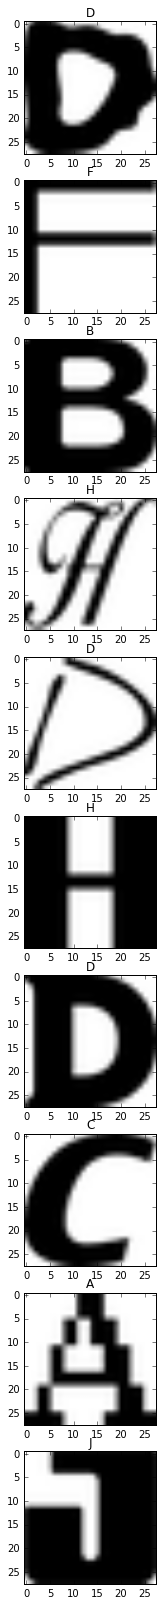

In [6]:
letters = ['A','B','C','D','E','F','G','H','I','J']
image_nb = 1873 # Image nb for each letter of the test dataset
#pixel_depth = 255.0  # Number of levels per pixel.
#image_size = 28  # Pixel width and height
n = 10 # number of images to display

figure = plt.figure(figsize = (n*image_size, image_size)) 
for x in range(n):
    letter = random.sample(letters,1)[0]
    imageIndex = random.sample(range(image_nb),1)[0]
    with open(testRoot+letter+'.pickle', 'rb') as f:
        dataset = pickle.load(f)
    plt.subplot(n,1,1+x)
    plt.imshow(dataset[imageIndex,:,:], cmap="binary")
    plt.title(letter)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

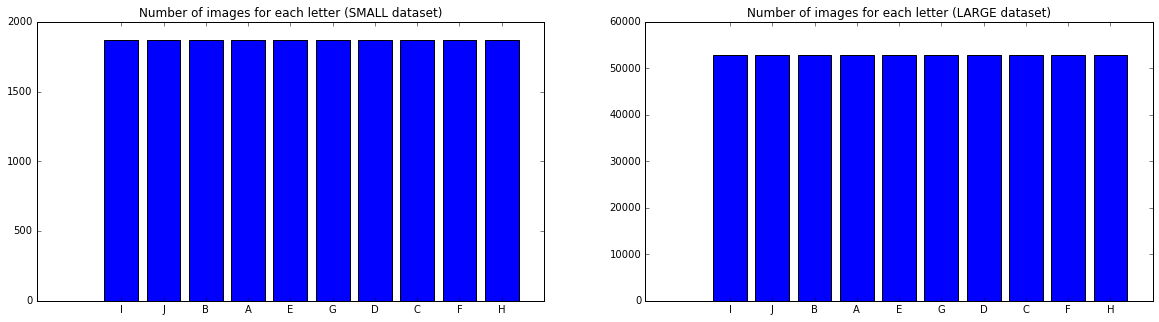

In [7]:
def getLetterNumber(dataset_root):
    dico = {}
    for letter in letters:
        with open(dataset_root+letter+'.pickle', 'rb') as f:
            dataset = pickle.load(f)
            dico[letter] = np.size(dataset,0)
    return dico

fig = plt.figure(figsize =(20,5))

# Check for SMALL dataset
dico = getLetterNumber(testRoot)
plt.subplot(1,2,1)
plt.bar(range(len(dico)), dico.values(), align='center')
plt.xticks(range(len(dico)), dico.keys())
plt.title('Number of images for each letter (SMALL dataset)')

# Check for LARGE dataset
dico = getLetterNumber(trainRoot)
plt.subplot(1,2,2)
plt.bar(range(len(dico)), dico.values(), align='center')
plt.xticks(range(len(dico)), dico.keys())
plt.title('Number of images for each letter (LARGE dataset)')

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [7]:
# Account for fileName not being sort by name in train_dataset...
def fileName2int(file):
    letter = os.path.splitext(os.path.basename(file))[0]
    return letters.index(letter)


def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for _, pickle_file in enumerate(pickle_files):
    label = fileName2int(pickle_file)
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

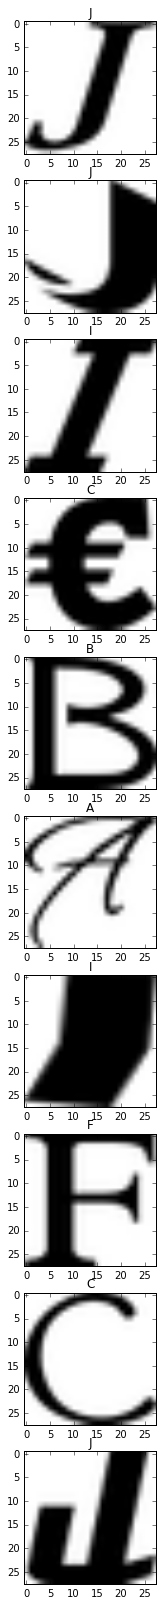

In [9]:
# We display n random images and their associated label to check consistency has been preserved
n = 10 # number of images to display

def checkReshuffling(dataset,labels):
    dataset_size = dataset.shape[0]
    idxs = random.sample(range(dataset_size),n)

    fig = plt.figure(figsize = (n*image_size, image_size))
    for c, idx in enumerate(idxs):
        plt.subplot(n,1,1+c)
        plt.imshow(dataset[idx,:,:], cmap='binary')
        plt.title(letters[labels[idx]])

checkReshuffling(train_dataset,train_labels)

Finally, let's save the data for later reuse:

In [11]:
#pickle_file = 'notMNIST.pickle'
pickle_file = mainRoot + 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [10]:
# REMARK : previous treatments can't produce duplicates so if any, they were present in the initial datatsets.

# EXACT duplicates
import hashlib
def exactHash(x):
    return hashlib.sha1(x).digest()


# NEAR duplicates
# based on https://realpython.com/blog/python/fingerprinting-images-for-near-duplicate-detection/
import PIL
import imagehash
def nearHash(x): # Rescale the previously normalized array and compute its dhash
    #PIL.Image.fromarray(255/2 + 255.*x).show()
    return str(imagehash.dhash(PIL.Image.fromarray(255/2 + 255.*x)))


import time

def computeOverlap(method):
    if method == 'exact':
        myHash = exactHash
    elif method == 'near':
        myHash = nearHash

    t1 = time.time()

    train_hashes = [myHash(x) for x in train_dataset]
    valid_hashes = [myHash(x) for x in valid_dataset]
    test_hashes  = [myHash(x) for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]

    t2 = time.time()

    print("Time: %0.2fs" % (t2 - t1))
    print("valid -> train %s overlap: %d samples" % (method,valid_in_train.sum()))
    print("test  -> train %s overlap: %d samples" % (method,test_in_train.sum()))
    print("test  -> valid %s overlap: %d samples" % (method,test_in_valid.sum()))

    return valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean


valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean = computeOverlap('exact')
valid_dataset_clean_near, valid_labels_clean_near, test_dataset_clean_near, test_labels_clean_near = computeOverlap('near')

Time: 1.67s
valid -> train exact overlap: 1102 samples
test  -> train exact overlap: 1294 samples
test  -> valid exact overlap: 218 samples
Time: 35.47s
valid -> train near overlap: 3129 samples
test  -> train near overlap: 3606 samples
test  -> valid near overlap: 982 samples


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

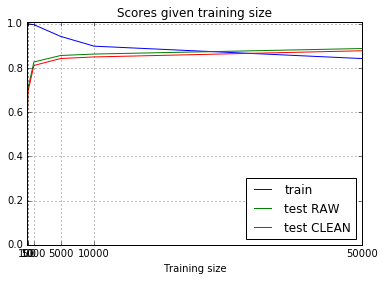

In [105]:
train_size = np.size(train_dataset,0)
test_size = np.size(test_dataset_clean,0)
#nn = [ 50, 100, 1000, 5000, train_size ] # Number of training samples
nn = [ 50, 100, 1000, 5000, 10000, 50000 ] # Number of training samples
data = np.ndarray(shape=(len(nn),4), dtype=np.float32)

X_test_raw = test_dataset.reshape( np.size(test_dataset,0), 28*28 )
y_test_raw = test_labels

X_test_clean = test_dataset_clean.reshape( np.size(test_dataset_clean,0), 28*28 )
y_test_clean = test_labels_clean


model = LogisticRegression()
for i, n in enumerate(nn):
    X_train = train_dataset[0:n,:,:].reshape(n,28*28)
    y_train = train_labels[0:n]

    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_raw_score = model.score(X_test_raw, y_test_raw)
    test_clean_score = model.score(X_test_clean, y_test_clean)

    data[i,:] = [n, train_score, test_raw_score, test_clean_score]
    print('LogisticRegression score for %i training samples : %.2f' % (n,test_score))

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('train','test RAW', 'test CLEAN'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()